In [18]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy import stats

# Make the graphs a bit prettier, and bigger
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

## Goal Input Data
- Month: int
- hour: int
- Temperature: float
- Presure: float
- U: float
- Wind dir: One-hot
- Wind speed

- SO2
- PM10
- PM25

In [185]:
def datetime2ymd(in_df, out_df):
    out_df["year"]  = in_df["DateTime"].astype(str).str[:4].astype(int)
    out_df["month"] = in_df["DateTime"].astype(str).str[5:7].astype(int)
    out_df["day"]   = in_df["DateTime"].astype(str).str[8:10].astype(int)
    out_df["hour"]  = in_df["DateTime"].astype(str).str[11:13].astype(int)
    out_df["min"]   = in_df["DateTime"].astype(str).str[14:].astype(int)
    
    return out_df

def datetime2dmy(in_df, out_df):
    out_df["year"]  = in_df["DateTime"].astype(str).str[6:10].astype(int)
    out_df["month"] = in_df["DateTime"].astype(str).str[3:5].astype(int)
    out_df["day"]   = in_df["DateTime"].astype(str).str[:2].astype(int)
    out_df["hour"]  = in_df["DateTime"].astype(str).str[11:13].astype(int)
    out_df["min"]   = in_df["DateTime"].astype(str).str[14:].astype(int)
    
    return out_df

In [171]:
raw_data = pd.read_csv("../LYBE.26.09.2012.03.04.2021.1.0.0.en.utf8.00000000.csv", sep=",", low_memory=True)
raw_data["DateTime"] = raw_data["Local time in Belgrade / Nicola Tesla (airport)"]
weather_data = pd.DataFrame()

In [172]:
raw_data.head()

,Local time in Belgrade / Nicola Tesla (airport),T,P0,P,U,DD,Ff,ff10,WW,W'W',c,VV,Td,DateTime
0,03.04.2021 16:00,9.0,751.2,760.5,82.0,Wind blowing from the west,6.0,NaN,NaN,NaN,Few clouds (10-30%) 900 m,10.0 and more,6.0,03.04.2021 16:00
1,03.04.2021 15:30,9.0,751.2,760.5,82.0,Wind blowing from the west-southwest,5.0,NaN,Light rain,NaN,Broken clouds (60-90%) 900 m,10.0 and more,6.0,03.04.2021 15:30
2,03.04.2021 15:00,8.0,751.8,761.2,87.0,Wind blowing from the south-west,3.0,NaN,Light rain,NaN,"Few clouds (10-30%) 600 m, broken clouds (60-9...",7,6.0,03.04.2021 15:00
3,03.04.2021 14:30,8.0,751.8,761.2,87.0,Wind blowing from the west-southwest,4.0,NaN,Light rain,NaN,"Scattered clouds (40-50%) 600 m, broken clouds...",7,6.0,03.04.2021 14:30
4,03.04.2021 14:00,8.0,751.8,761.2,87.0,Wind blowing from the west-southwest,5.0,NaN,Light rain,NaN,"Scattered clouds (40-50%) 450 m, broken clouds...",6,6.0,03.04.2021 14:00


In [173]:
weather_data = datetime2dmy(raw_data, weather_data)

In [174]:
copy_columns = ["T", "P0", "P", "U", "Td"]
weather_data[copy_columns] = raw_data[copy_columns]

In [175]:
weather_data["VV"] = raw_data["VV"]
weather_data.loc[raw_data.VV == "10.0 and more", "VV"] = 10

Drizzle, duststorm, light rain, rain, heavy, smoke, snow, Thunderstorm
mist, fog, haze

In [177]:
ww_data = pd.DataFrame(raw_data.WW.str.lower().str.split(',')).fillna("")

weather_data["mist"] = pd.DataFrame([int("mist" in x) for x in ww_data.WW])
weather_data["rain"] = pd.DataFrame([int("rain" in x) for x in ww_data.WW])
weather_data["light_rain"] = pd.DataFrame([int("light rain" in x) for x in ww_data.WW])
weather_data["fog"] = pd.DataFrame([int("fog" in x) for x in ww_data.WW])
weather_data["heavythunderstorm"] = pd.DataFrame([int("heavy thunderstorm" in x) for x in ww_data.WW])
weather_data["snow"] = pd.DataFrame([int("snow" in x) for x in ww_data.WW])
weather_data["smoke"] = pd.DataFrame([int("smoke" in x) for x in ww_data.WW])
weather_data["thunderstorm"] = pd.DataFrame([int("thunderstorm" in x) for x in ww_data.WW])
weather_data["duststorm"] = pd.DataFrame([int("duststorm" in x) for x in ww_data.WW])

In [178]:
weather_data

,year,month,day,hour,min,T,P0,P,U,Td,VV,mist,rain,light_rain,fog,heavythunderstorm,snow,smoke,thunderstorm,duststorm
0,2021,4,3,16,0,9.0,751.2,760.5,82.0,6.0,10,0,0,0,0,0,0,0,0,0
1,2021,4,3,15,30,9.0,751.2,760.5,82.0,6.0,10,0,0,1,0,0,0,0,0,0
2,2021,4,3,15,0,8.0,751.8,761.2,87.0,6.0,7,0,0,1,0,0,0,0,0,0
3,2021,4,3,14,30,8.0,751.8,761.2,87.0,6.0,7,0,0,1,0,0,0,0,0,0
4,2021,4,3,14,0,8.0,751.8,761.2,87.0,6.0,6,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136804,2012,9,26,13,0,29.0,751.8,760.5,33.0,11.0,10,0,0,0,0,0,0,0,0,0
136805,2012,9,26,12,0,28.0,751.8,760.5,35.0,11.0,10,0,0,0,0,0,0,0,0,0
136806,2012,9,26,11,0,26.0,751.7,760.5,39.0,11.0,10,0,0,0,0,0,0,0,0,0
136807,2012,9,26,10,0,24.0,751.6,760.5,50.0,13.0,10,0,0,0,0,0,0,0,0,0


In [181]:
weather_data = pd.concat([weather_data, pd.get_dummies(raw_data.DD)], axis=1)

In [182]:
weather_data.count()

year                                     136809
month                                    136809
day                                      136809
hour                                     136809
min                                      136809
T                                        136796
P0                                       136792
P                                        136802
U                                        136794
Td                                       136794
VV                                       136806
mist                                     136809
rain                                     136809
light_rain                               136809
fog                                      136809
heavythunderstorm                        136809
snow                                     136809
smoke                                    136809
thunderstorm                             136809
duststorm                                136809
Calm, no wind                           

# Load Target Data

In [183]:
target_df = pd.read_csv("MATF_Hackathon_2021/SviPodaci_mStanica_BeogradNBG.csv")
clean_target = pd.DataFrame()

target_df = target_df.rename(columns={"Datum_i_Vreme": "DateTime"})

target_df.head()

,DateTime,MernaStanica,B,CO,NO2,O3,PM10,PM25,SO2
0,2012-06-11 16:00,Beograd Novi Beograd,0.269729,0.590997,63.094881,53.622829,23.109444,9.742659,2.789345
1,2015-03-09 08:00,Beograd Novi Beograd,2.042423,1.113447,19.640968,56.213282,26.856319,19.293327,84.947258
2,2010-05-19 09:00,Beograd Novi Beograd,0.778962,0.905177,26.346479,NaN,22.899085,12.057213,2.703677
3,2010-07-17 00:00,Beograd Novi Beograd,0.686226,0.994739,31.578526,44.185095,29.241251,22.910294,8.567367
4,2018-05-01 00:00,Beograd Novi Beograd,NaN,0.250000,NaN,43.600000,NaN,NaN,12.900000


In [186]:
clean_target = datetime2ymd(target_df, clean_target)
copy_columns = ["B", "CO", "NO2", "O3", "PM10", "PM25", "SO2"]

clean_target[copy_columns] = target_df[copy_columns]
clean_target = clean_target.sort_values(by=["year", "month", "day", "hour", "min"])

clean_target.head()

,year,month,day,hour,min,B,CO,NO2,O3,PM10,PM25,SO2
23026,2009,11,17,20,0,NaN,NaN,NaN,NaN,NaN,54.221211,NaN
28045,2009,11,17,21,0,NaN,NaN,NaN,NaN,NaN,61.848214,NaN
52868,2009,11,17,22,0,NaN,NaN,NaN,NaN,NaN,47.386997,NaN
68772,2009,11,17,23,0,NaN,NaN,NaN,NaN,NaN,42.317648,NaN
41525,2009,11,18,0,0,NaN,NaN,NaN,NaN,NaN,41.457331,NaN


In [190]:
final_data = weather_data.merge(clean_target)

In [201]:

final_data.count()

year                                     73977
month                                    73977
day                                      73977
hour                                     73977
min                                      73977
T                                        73971
P0                                       73969
P                                        73973
U                                        73971
Td                                       73971
VV                                       73975
mist                                     73977
rain                                     73977
light_rain                               73977
fog                                      73977
heavythunderstorm                        73977
snow                                     73977
smoke                                    73977
thunderstorm                             73977
duststorm                                73977
Calm, no wind                            73977
Wind blowing 

In [194]:
final_data.to_csv('training_test_data.csv')

In [80]:
def calculate_aqi(data):
    
    boundaries = {
    "PM10" : [0, 50, 100, 250, 350, 430],
    "PM25" : [0, 30, 60, 90, 120, 250],
    "NO2" : [0, 40, 80, 180, 280, 400],
    "O3" : [0, 50, 100, 168, 208, 748],
    "CO" : [0, 1, 2, 10, 17, 34],
    "SO2" : [0, 40, 80, 380, 800, 1600],
    "AQI" : [0, 50, 100, 200, 300, 400, 500]
    }

    pollusions = ["CO", "NO2", "O3", "PM10", "PM25", "SO2"]

    aqi_max = 0
    for pol in pollusions:
        j = len(boundaries[pol])-1
        if data[pol] == -1:
            continue
        while data[pol] < boundaries[pol][j]:
            j-=1
        low_index = j
        high_index = j+1
        if high_index < len(boundaries[pol]):
            delta_boundaries = boundaries[pol][high_index] - boundaries[pol][low_index]
        else:
            delta_boundaries = boundaries[pol][low_index] - boundaries[pol][low_index-1]
        aqi = ((boundaries["AQI"][high_index] - boundaries["AQI"][low_index]) / \
                 delta_boundaries) * \
                (data[pol] - boundaries[pol][low_index]) + boundaries["AQI"][low_index]
        if aqi > aqi_max:
            aqi_max = aqi
    return aqi_max

In [19]:
df = pd.read_csv('training_test_data.csv')

In [20]:
df

,Unnamed: 0,year,month,day,hour,min,T,P0,P,U,Td,VV,mist,rain,light_rain,fog,heavythunderstorm,snow,smoke,thunderstorm,duststorm,"Calm, no wind",Wind blowing from the east,Wind blowing from the east-northeast,Wind blowing from the east-southeast,Wind blowing from the north,Wind blowing from the north-east,Wind blowing from the north-northeast,Wind blowing from the north-northwest,Wind blowing from the north-west,Wind blowing from the south,Wind blowing from the south-east,Wind blowing from the south-southeast,Wind blowing from the south-southwest,Wind blowing from the south-west,Wind blowing from the west,Wind blowing from the west-northwest,Wind blowing from the west-southwest,variable wind direction,B,CO,NO2,O3,PM10,PM25,SO2
0,0,2021,3,31,23,0,12.0,757.3,766.6,67.0,6.0,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,9.603410,1.064641,69.537103,2.593500,89.953333,61.856333,14.941649
1,1,2021,3,31,22,0,13.0,757.3,766.6,63.0,6.0,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,7.899329,0.971274,67.659273,6.174525,81.218333,57.830667,12.856076
2,2,2021,3,31,21,0,14.0,757.4,766.6,59.0,6.0,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,7.583297,0.841582,74.383116,8.016575,63.256667,32.857333,13.339855
3,3,2021,3,31,20,0,15.0,757.4,766.6,55.0,6.0,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3.820465,0.819488,93.400531,9.363200,62.978000,32.473103,13.850263
4,4,2021,3,31,19,0,17.0,758.1,767.3,49.0,6.0,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2.099754,0.635298,74.045171,28.874300,40.234667,17.454138,11.051894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73972,73972,2012,9,26,13,0,29.0,751.8,760.5,33.0,11.0,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,NaN,0.226492,9.884645,103.494503,NaN,NaN,21.156314
73973,73973,2012,9,26,12,0,28.0,751.8,760.5,35.0,11.0,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,0.251911,14.594098,99.965848,NaN,NaN,43.954147
73974,73974,2012,9,26,11,0,26.0,751.7,760.5,39.0,11.0,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,NaN,0.225366,22.264295,87.289010,NaN,NaN,161.803991
73975,73975,2012,9,26,10,0,24.0,751.6,760.5,50.0,13.0,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,NaN,0.211371,16.791011,83.698285,NaN,NaN,94.576963


# Website needs
- daily prediction.csv
    - x: hour, y:aqi 
- last month
    - x: days, y:__

In [125]:
daily_pred = pd.DataFrame()
daily_pred = df.loc[(df["year"] == 2021) & (df["month"] == 2) & (df["day"] == 10),
                    ["hour", "B", "CO", "NO2", "O3", "PM10", "PM25", "SO2"]]
daily_pred = pd.DataFrame(daily_pred)
aqi = pd.DataFrame({'AQI': [calculate_aqi(daily_pred.iloc[i]) for i in range(daily_pred.shape[0])]})
daily_pred["AQI"] = aqi["AQI"].values

In [126]:
daily_pred.to_csv('website_daily.csv')

In [97]:
daily_pred.shape

(24, 8)

,hour,B,CO,NO2,O3,PM10,PM25,SO2,AQI
1131,23,5.331410,0.603690,28.205710,22.437100,32.673448,30.422333,17.280207,50.703889
1132,22,4.643067,0.718802,59.169185,8.721475,32.327966,29.800833,14.010931,73.961481
1133,21,3.067725,0.563909,49.231670,21.625800,21.383621,18.856500,13.604379,61.539587
1134,20,3.789868,0.449224,23.981390,48.614825,14.164000,12.506667,12.933747,48.614825
1135,19,2.808861,0.519099,50.873576,23.228450,19.496610,15.520500,14.571492,63.591969
1136,18,2.205619,0.404745,24.711480,49.110250,10.946667,8.991667,14.154289,49.110250
1137,17,2.708515,0.426955,20.841045,52.581550,16.739107,12.182167,12.209411,52.581550
1138,16,2.294508,0.430935,20.417019,52.385375,23.268966,14.611167,13.448594,52.385375
1139,15,1.896514,0.389950,14.598615,57.392825,15.476780,9.861667,12.655464,57.392825
1140,14,2.326339,0.375292,12.905699,57.788500,15.421695,9.075000,13.176080,57.788500


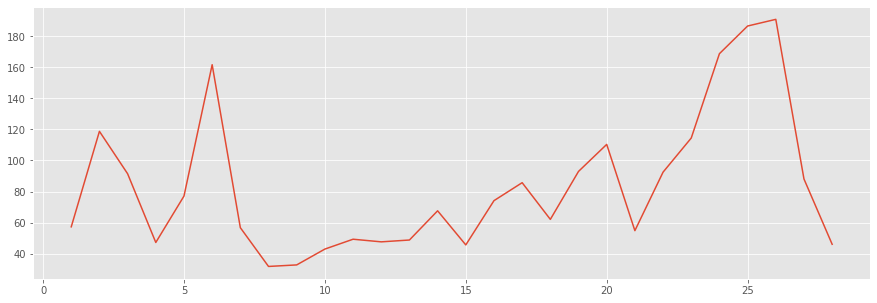

In [127]:
monthly_obs = pd.DataFrame()
monthly_obs = df.loc[(df["year"] == 2021) & (df["month"] == 2),
                    ["day", "B", "CO", "NO2", "O3", "PM10", "PM25", "SO2"]]

monthly_obs = monthly_obs.groupby('day').mean()

aqi = pd.DataFrame({'AQI': [calculate_aqi(monthly_obs.iloc[i]) for i in range(monthly_obs.shape[0])]})
monthly_obs["AQI"] = aqi["AQI"].values

plt.plot(monthly_obs["AQI"])

In [128]:
monthly_obs.to_csv('website_monthly.csv')

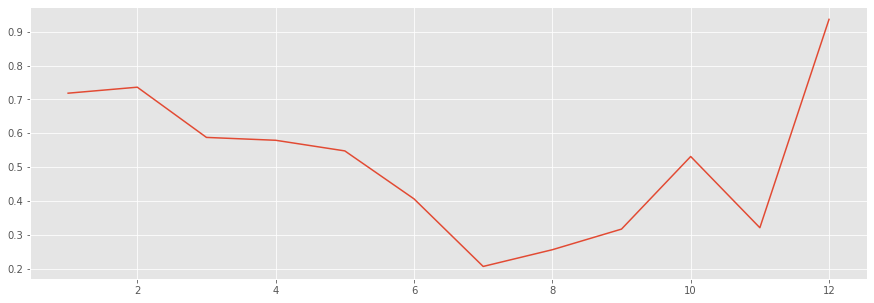

In [129]:
year_obs = pd.DataFrame()
year_obs = df.loc[(df["year"] == 2019),
                    ["month", "B", "CO", "NO2", "O3", "PM10", "PM25", "SO2"]]

year_obs = year_obs.groupby('month').mean()

aqi = pd.DataFrame({'AQI': [calculate_aqi(year_obs.iloc[i]) for i in range(year_obs.shape[0])]})
year_obs["AQI"] = aqi["AQI"].values


plt.plot(year_obs["CO"])

In [130]:
year_obs.to_csv('website_yearly.csv')

## Website usage

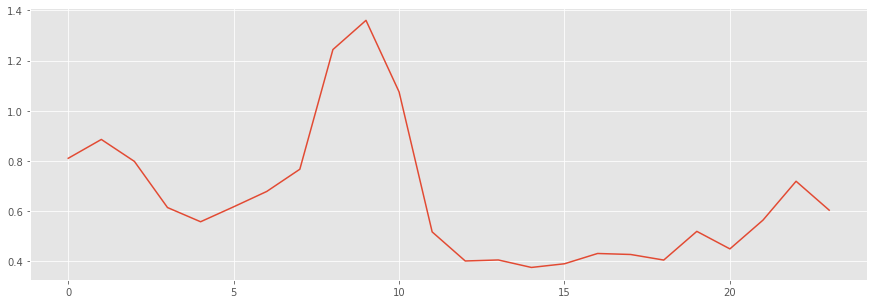

In [56]:
site_data = pd.read_csv('website_daily.csv')
plt.plot(site_data["hour"], site_data["CO"])

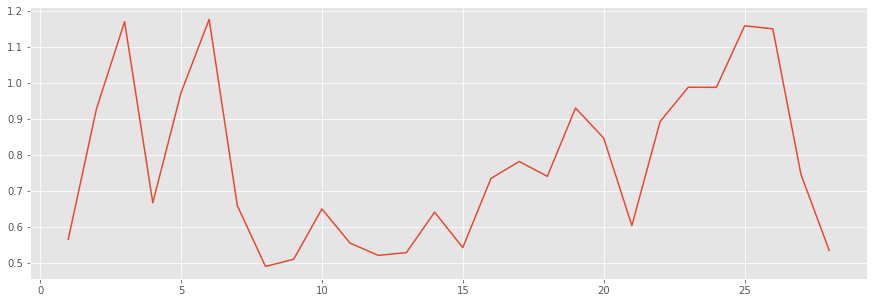

In [74]:
site_data = pd.read_csv('website_monthly.csv')
plt.plot(site_data["day"], site_data["CO"])